In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
pip install langchain

In [88]:
pip install -U langchain-groq

In [89]:
from langchain_groq import ChatGroq

In [ ]:
import os

os.environ["GROQ_API_KEY"] = "Your Groq Api Key"

In [91]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.0,
    max_retries=2,
    # other params...
)

In [92]:
pip install langgraph

In [93]:
import pandas as pd
import numpy as np
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import END, StateGraph
from typing import List

In [94]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

from typing import Tuple, List

def missing_value_summary(csv_path: str) -> Tuple[str, List[str]]:
    """
    Summarize missing values from a CSV file and return list of columns with missing values.

    Args:
        csv_path: Path to a CSV file.

    Returns:
        A tuple:
            - A string summary of missing values per column.
            - A list of column names that contain missing values.
    """
    df = pd.read_csv(csv_path)
    total = len(df)
    missing = df.isna().sum()

    lines = []
    missing_columns = []

    for col, count in missing.items():
        if count > 0:
            percent = (count / total) * 100
            lines.append(f"{col}: {count} missing ({percent:.2f}%)")
            missing_columns.append(col)

    summary = "No missing values found." if not lines else "\n".join(lines)
    return summary, missing_columns


def treat_missing_values(csv_path: str, columns: list, strategy: str = "mode") -> str:
    """
    Treat missing values in specified columns using the given strategy.

    Args:
        csv_path: Path to the input CSV file.
        columns: List of column names to treat.
        strategy: Strategy to use for imputation: 'mean', 'median', or 'mode'.

    Returns:
        Path to the new CSV file with treated values.
    """
    df = pd.read_csv(csv_path)

    for col in columns:
        if strategy == "mean":
            value = df[col].mean()
        elif strategy == "median":
            value = df[col].median()
        elif strategy == "mode":
            value = df[col].mode()[0]
        else:
            raise ValueError(f"Unsupported strategy: {strategy}")
        df[col].fillna(value, inplace=True)

    # Avoid appending '_treated' multiple times
    base, ext = os.path.splitext(csv_path)
    if not base.endswith("_treated"):
        output_path = f"{base}_treated{ext}"
    else:
        output_path = f"{base}{ext}"

    df.to_csv(output_path, index=False)
    print(f"Missing values in {columns} treated with strategy '{strategy}'. Saved to {output_path}")
    return output_path



tools = [missing_value_summary, treat_missing_values]
#tools = [missing_value_summary]
llm_with_tools = llm.bind_tools(tools)


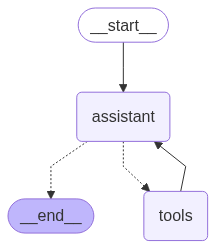

In [95]:

from langgraph.graph import START,StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import Runnable
from typing import TypedDict, Annotated, List, Union
from IPython.display import Image, display

# System message
#sys_msg = SystemMessage(content="Please check for missing data and decide how to treat them using an appropriate strategy.")
sys_msg = SystemMessage(content="""
You are a data cleaning agent.

1. When the user provides a CSV, always first call the `missing_value_summary` tool.
2. Use only the column names returned in `missing_columns` for any treatment.
3. Choose treatment based on data type:
   - If 'numeric': strategy can be 'mean', 'median', 'mode', or 'drop'.
   - If 'categorical': strategy can be 'mode' or 'drop'.
4. Never make up column names. Do not call `treat_missing_values` on columns not listed in `missing_columns`.
5. After treating missing values, use the new path (e.g. `customers_treated.csv`) in all future steps.
""")
# Node
def assistant(state: MessagesState):
    messages = [sys_msg] + state["messages"]
    result = llm_with_tools.invoke(messages)
    print("🔹 Assistant returned:", result)
    return {"messages": [result]}
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [96]:
messages = [HumanMessage(content="Please clean missing data in this file: /content/drive/MyDrive/Credit_Risk/Project2_Mt&E_Resources/dataset/customers.csv")]
#state = {"messages": messages}

messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()


🔹 Assistant returned: content='' additional_kwargs={'tool_calls': [{'id': 'call_9frt', 'function': {'arguments': '{"csv_path":"/content/drive/MyDrive/Credit_Risk/Project2_Mt\\u0026E_Resources/dataset/customers.csv"}', 'name': 'missing_value_summary'}, 'type': 'function'}, {'id': 'call_ew3s', 'function': {'arguments': '{"columns":["missing_columns"],"csv_path":"/content/drive/MyDrive/Credit_Risk/Project2_Mt\\u0026E_Resources/dataset/customers.csv","strategy":"mode"}', 'name': 'treat_missing_values'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 549, 'total_tokens': 639, 'completion_time': 0.12, 'prompt_time': 0.118036535, 'queue_time': 2.100478925, 'total_time': 0.238036535}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f7bd09b454', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--6807b1a2-4550-468c-a99a-7f5de3afa503-0' tool_calls=[{'name': 'missing_value_summary', 'args': {'csv_path': '/content/drive/MyDr

<ipython-input-94-9de9b3bf86db>:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(value, inplace=True)


Missing values in ['residence_type'] treated with strategy 'mode'. Saved to /content/drive/MyDrive/Credit_Risk/Project2_Mt&E_Resources/dataset/customers_treated.csv
🔹 Assistant returned: content='' additional_kwargs={'tool_calls': [{'id': 'call_yard', 'function': {'arguments': '{"csv_path":"/content/drive/MyDrive/Credit_Risk/Project2_Mt\\u0026E_Resources/dataset/customers_treated.csv"}', 'name': 'missing_value_summary'}, 'type': 'function'}, {'id': 'call_xyk7', 'function': {'arguments': '{"columns":["age","income"],"csv_path":"/content/drive/MyDrive/Credit_Risk/Project2_Mt\\u0026E_Resources/dataset/customers_treated.csv","strategy":"mean"}', 'name': 'treat_missing_values'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 96, 'prompt_tokens': 900, 'total_tokens': 996, 'completion_time': 0.128, 'prompt_time': 0.025657792, 'queue_time': 0.20281838200000002, 'total_time': 0.153657792}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f7bd09b454'

<ipython-input-94-9de9b3bf86db>:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(value, inplace=True)


Missing values in ['age', 'income'] treated with strategy 'mean'. Saved to /content/drive/MyDrive/Credit_Risk/Project2_Mt&E_Resources/dataset/customers_treated.csv
🔹 Assistant returned: content="The missing values in the 'residence_type' column have been treated using the 'mode' strategy. The missing values in the 'age' and 'income' columns have been treated using the 'mean' strategy." additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 1045, 'total_tokens': 1090, 'completion_time': 0.073588704, 'prompt_time': 0.030261866, 'queue_time': 0.201520126, 'total_time': 0.10385057}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'stop', 'logprobs': None} id='run--d30e7152-b54a-49d7-b33c-ab1a53200d41-0' usage_metadata={'input_tokens': 1045, 'output_tokens': 45, 'total_tokens': 1090}
================================ Human Message =================================

Please clean missing data in this file:

In [97]:
df_m = pd.read_csv("/content/drive/MyDrive/Credit_Risk/Project2_Mt&E_Resources/dataset/customers_treated.csv")
df_m.isna().sum()

,0
cust_id,0
age,0
gender,0
marital_status,0
employment_status,0
income,0
number_of_dependants,0
residence_type,0
years_at_current_address,0
city,0
